In [25]:
import torch    
import json 
from ptlpinns.models import model, transfer
from ptlpinns.perturbation import LPM, standard
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

### Load model

In [26]:
overdamped_path = "/home/dda24/PTL-PINNs/ptlpinns/models/train/undamped_k12"
overdamped_name = "model_undamped_k12.pth"
overdamped_model, training_log = model.load_model(overdamped_path, overdamped_name)

12 True True True 1.0 16 [256, 256, 512]


### Problem definition

In [27]:
N = 5120
t_span = (0, 20)
t_eval = np.linspace(t_span[0], t_span[1], N)

### Compute latent representations

In [28]:
H_dict = transfer.compute_H_dict(overdamped_model, N=N, bias=True, t_span=t_span)

### Transfer parameters

In [29]:
w_list_transfer = [1, 1, 1, 1, 1]
zeta_list = [5, 10, 30, 40, 60]

#forcing_freq = [[1]]
#forcing_coef = [[1]]

def forcing(numpy=False):
    if not numpy:
        def force(t):
            return torch.stack((torch.zeros_like(t), torch.cos(t)), dim=1)
    else:
        def force(t):
            return np.stack((np.zeros_like(t), np.cos(t)), axis=1)
    return force


forcing_list = [forcing(True), forcing(True), forcing(True), forcing(True), forcing(True)]

forcing_1D = lambda t: np.cos(t)
ic_list = [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
epsilon_list = [0.7, 0.7, 0.7, 0.7, 0.7]
p_list = [9]
q = 3

### Numerical solver

In [30]:
numerical_undamped_duffing_list = []

for zeta in zeta_list:
    ode = equations.ode_oscillator_1D(w_0=w_list_transfer[0], zeta=zeta, forcing_1D=forcing_1D, q=q, epsilon=epsilon_list[0])
    numerical_undamped_duffing_list.append(numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic_list[0]))

### PINN

In [31]:
NN_TL_solution, perturbation_solution, _ = transfer.compute_perturbation_solution(w_list_transfer, zeta_list, epsilon_list, p_list, ic_list, forcing_list, H_dict, t_eval, training_log, all_p=True, comp_time=False, solver="standard", power=q)
NN_TL_solution = NN_TL_solution.squeeze()

In [32]:
NN_TL_solution.shape

(5120, 5, 2)

In [33]:
PINN_solution = []

for perturbation_zeta in perturbation_solution:

    perturbation = []
    for perturbation_order in perturbation_zeta:

        perturbation.append(perturbation_order[:, 0])

    PINN_solution.append(standard.calculate_general_series(perturbation, epsilon_list[0]))

zeta: 5, order: 0, mean error absolute: 0.08619676330420954
zeta: 5, order: 1, mean error absolute: 0.01627631589224298
zeta: 5, order: 2, mean error absolute: 0.026010230061471806
zeta: 5, order: 3, mean error absolute: 0.0059079724868567034
zeta: 5, order: 4, mean error absolute: 0.01665249146961358
zeta: 5, order: 5, mean error absolute: 0.010451004757537968
zeta: 5, order: 6, mean error absolute: 0.014104829466074826
zeta: 5, order: 7, mean error absolute: 0.011895509483729666
zeta: 5, order: 8, mean error absolute: 0.013257416100679367


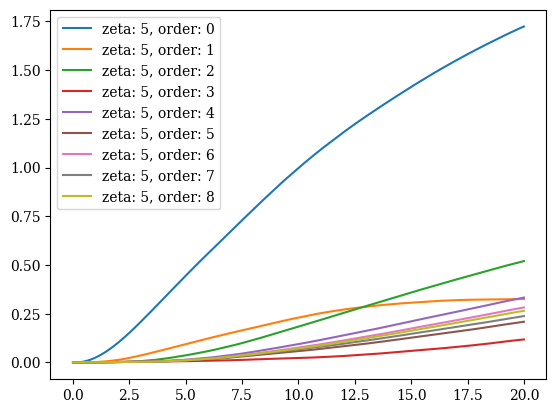

zeta: 10, order: 0, mean error absolute: 0.10134256333558127
zeta: 10, order: 1, mean error absolute: 0.007893932962330976
zeta: 10, order: 2, mean error absolute: 0.02816884007120286
zeta: 10, order: 3, mean error absolute: 0.014192758055394602
zeta: 10, order: 4, mean error absolute: 0.02023442693599469
zeta: 10, order: 5, mean error absolute: 0.017470312574997048
zeta: 10, order: 6, mean error absolute: 0.018784856661413947
zeta: 10, order: 7, mean error absolute: 0.01814163316427096
zeta: 10, order: 8, mean error absolute: 0.018463360261343868


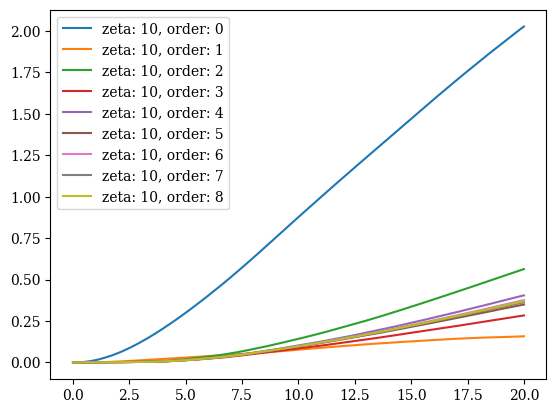

zeta: 30, order: 0, mean error absolute: 0.07074386312982164
zeta: 30, order: 1, mean error absolute: 0.00801821724077961
zeta: 30, order: 2, mean error absolute: 0.01744620965891927
zeta: 30, order: 3, mean error absolute: 0.015726052326642793
zeta: 30, order: 4, mean error absolute: 0.016061994729717925
zeta: 30, order: 5, mean error absolute: 0.015993179759524957
zeta: 30, order: 6, mean error absolute: 0.016007799143185696
zeta: 30, order: 7, mean error absolute: 0.016004593558103186
zeta: 30, order: 8, mean error absolute: 0.01600531829057435


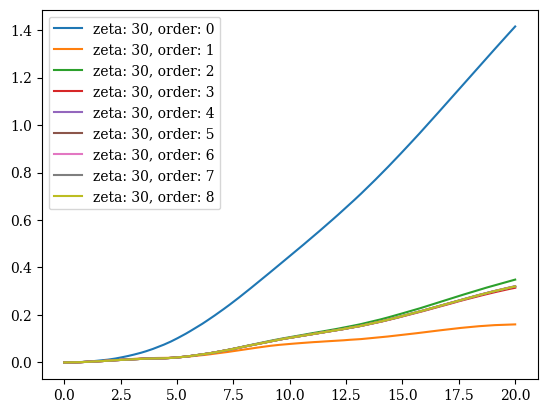

zeta: 40, order: 0, mean error absolute: 0.0551578689751349
zeta: 40, order: 1, mean error absolute: 0.00803500703188018
zeta: 40, order: 2, mean error absolute: 0.01347837509873944
zeta: 40, order: 3, mean error absolute: 0.012730536701317453
zeta: 40, order: 4, mean error absolute: 0.012839053737206663
zeta: 40, order: 5, mean error absolute: 0.01282260656673181
zeta: 40, order: 6, mean error absolute: 0.012825197147566237
zeta: 40, order: 7, mean error absolute: 0.012824772425191084
zeta: 40, order: 8, mean error absolute: 0.012824845285060876


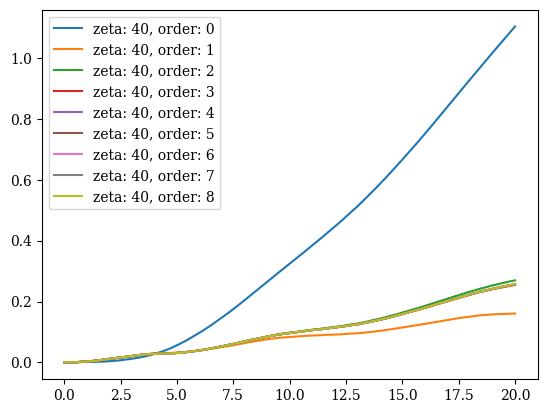

zeta: 60, order: 0, mean error absolute: 0.0348549958105069
zeta: 60, order: 1, mean error absolute: 0.00723632023655524
zeta: 60, order: 2, mean error absolute: 0.008605364158825277
zeta: 60, order: 3, mean error absolute: 0.008439044843083308
zeta: 60, order: 4, mean error absolute: 0.008455067775194239
zeta: 60, order: 5, mean error absolute: 0.008453438822085593
zeta: 60, order: 6, mean error absolute: 0.008453609876497886
zeta: 60, order: 7, mean error absolute: 0.008453591132311495
zeta: 60, order: 8, mean error absolute: 0.008453593302484502


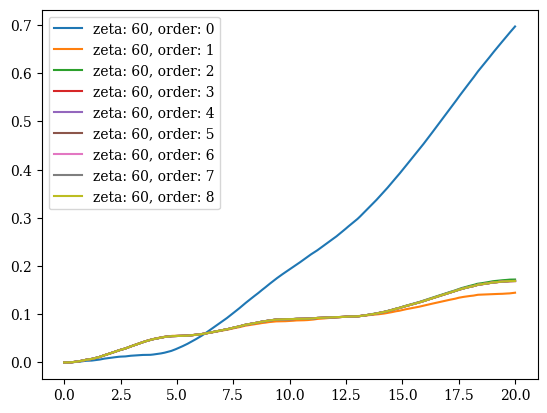

In [34]:
for i in range(len(PINN_solution)):

    for k in range(p_list[0]):

        error = np.abs(numerical_undamped_duffing_list[i][0, :] - PINN_solution[i][k])
        print(f"zeta: {zeta_list[i]}, order: {k}, mean error absolute: {np.mean(error)}")
        cumulative_error = cumulative_trapezoid(error, t_eval, initial=0) 
        plt.plot(t_eval, cumulative_error, label=f"zeta: {zeta_list[i]}, order: {k}")

    plt.legend()
    plt.show()

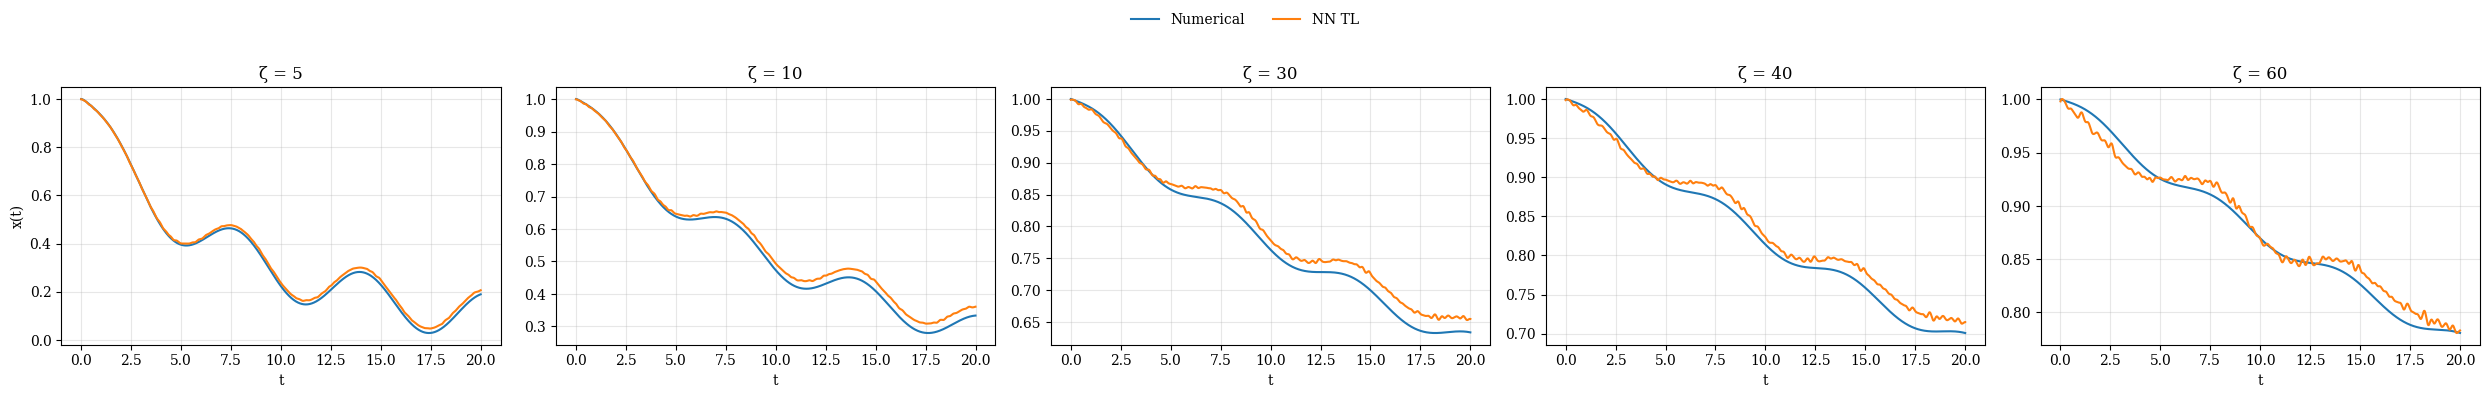

In [35]:
import numpy as np
import matplotlib.pyplot as plt

n = len(zeta_list)
fig, axes = plt.subplots(1, n, figsize=(5*n, 4), sharex=True)  # no sharey
axes = np.atleast_1d(axes)

for i, ax in enumerate(axes):
    y_num = numerical_undamped_duffing_list[i][0, :]
    y_nn  = NN_TL_solution[:, i, 0]

    ax.plot(t_eval, y_num, label="Numerical")
    ax.plot(t_eval, y_nn,  label="NN TL")
    ax.set_title(f"ζ = {zeta_list[i]}")
    ax.set_xlabel("t")
    if i == 0: ax.set_ylabel("x(t)")
    ax.grid(alpha=0.3)

    # independent y-limits per subplot (with padding)
    y_min = min(np.min(y_num), np.min(y_nn))
    y_max = max(np.max(y_num), np.max(y_nn))
    pad = 0.05 * max(1e-12, (y_max - y_min))
    ax.set_ylim(y_min - pad, y_max + pad)

# shared legend at the top with reserved space
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()


zeta: 5, mean Error: 1.240e-02
zeta: 10, mean Error: 1.830e-02
zeta: 30, mean Error: 1.601e-02
zeta: 40, mean Error: 1.282e-02
zeta: 60, mean Error: 8.454e-03


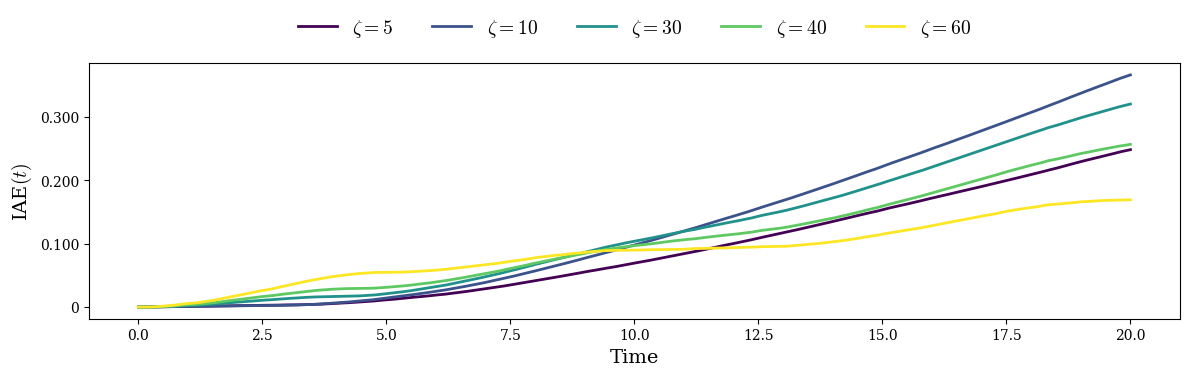

In [36]:
standard.plot_IAE_multiple_zeta(zeta_list, t_eval, NN_TL_solution, numerical_undamped_duffing_list)